# Multilabel classification on PETA dataset using python data-layers

### 1. Preliminaries

* First, make sure you compile caffe using
WITH_PYTHON_LAYER := 1

* Second, download PASCAL VOC 2012. It's available here: http://host.robots.ox.ac.uk/pascal/VOC/voc2012/index.html

* Third, import modules:

In [1]:
import sys 
import os

import numpy as np
import os.path as osp
import matplotlib.pyplot as plt

from copy import copy

% matplotlib inline
plt.rcParams['figure.figsize'] = (6, 6)

caffe_root = '../'  # this file is expected to be in {caffe_root}/examples
sys.path.append(caffe_root + 'python')
import caffe # If you get "No module named _caffe", either you have not built pycaffe or you have the wrong path.

from caffe import layers as L, params as P # Shortcuts to define the net prototxt.

sys.path.append("pycaffe/layers") # the datalayers we will use are in this directory.
sys.path.append("pycaffe") # the tools file is in this folder

import tools #this contains some tools that we need

* Fourth, set data directories and initialize caffe

In [2]:
# set data root directory, e.g:
peta_root = osp.join('/root/data/PETA/')

# these are the PASCAL classes, we'll need them later.
#classes = np.asarray(['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'])

# make sure we have the caffenet weight downloaded.
if not os.path.isfile(caffe_root + 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'):
    print("Downloading pre-trained CaffeNet model...")
    !../scripts/download_model_binary.py ../models/bvlc_reference_caffenet

# initialize caffe for gpu mode
caffe.set_mode_gpu()
caffe.set_device(4)

### 2. Define network prototxts

* Let's start by defining the nets using caffe.NetSpec. Note how we used the SigmoidCrossEntropyLoss layer. This is the right loss for multilabel classification. Also note how the data layer is defined.

In [4]:
# helper function for common structures
def conv_relu(bottom, ks, nout, stride=1, pad=0, group=1):
    conv = L.Convolution(bottom, kernel_size=ks, stride=stride,
                                num_output=nout, pad=pad, group=group)
    return conv, L.ReLU(conv, in_place=True)

# another helper function
def fc_relu(bottom, nout):
    fc = L.InnerProduct(bottom, num_output=nout)
    return fc, L.ReLU(fc, in_place=True)

# yet another helper function
def max_pool(bottom, ks, stride=1):
    return L.Pooling(bottom, pool=P.Pooling.MAX, kernel_size=ks, stride=stride)

# main netspec wrapper
def caffenet_multilabel(data_layer_params, datalayer):
    # setup the python data layer 
    n = caffe.NetSpec()
    n.data, n.label = L.Python(module = 'peta_multilabel_datalayers', layer = datalayer, 
                               ntop = 2, param_str=str(data_layer_params))

    # the net itself
    n.conv1, n.relu1 = conv_relu(n.data, 11, 96, stride=4)
    n.pool1 = max_pool(n.relu1, 3, stride=2)
    n.norm1 = L.LRN(n.pool1, local_size=5, alpha=1e-4, beta=0.75)
    n.conv2, n.relu2 = conv_relu(n.norm1, 5, 256, pad=2, group=2)
    n.pool2 = max_pool(n.relu2, 3, stride=2)
    n.norm2 = L.LRN(n.pool2, local_size=5, alpha=1e-4, beta=0.75)
    n.conv3, n.relu3 = conv_relu(n.norm2, 3, 384, pad=1)
    n.conv4, n.relu4 = conv_relu(n.relu3, 3, 384, pad=1, group=2)
    n.conv5, n.relu5 = conv_relu(n.relu4, 3, 256, pad=1, group=2)
    n.pool5 = max_pool(n.relu5, 3, stride=2)
    n.fc6, n.relu6 = fc_relu(n.pool5, 4096)
    n.drop6 = L.Dropout(n.relu6, in_place=True)
    n.fc7, n.relu7 = fc_relu(n.drop6, 4096)
    n.drop7 = L.Dropout(n.relu7, in_place=True)
    n.score = L.InnerProduct(n.drop7, num_output=7)
    n.loss = L.SigmoidCrossEntropyLoss(n.score, n.label)
    
    return str(n.to_proto())

### 3. Write nets and solver files

* Now we can crete net and solver prototxts. For the solver, we use the CaffeSolver class from the "tools" module

In [5]:
workdir = './peta_multilabel_with_datalayer'
if not os.path.isdir(workdir):
    os.makedirs(workdir)

solverprototxt = tools.CaffeSolver(trainnet_prototxt_path = osp.join(workdir, "trainnet.prototxt"), testnet_prototxt_path = osp.join(workdir, "valnet.prototxt"))
solverprototxt.sp['display'] = "1"
solverprototxt.sp['base_lr'] = "0.0001"
solverprototxt.write(osp.join(workdir, 'solver.prototxt'))

# write train net.
with open(osp.join(workdir, 'trainnet.prototxt'), 'w') as f:
    # provide parpeta_multilabel_with_datalayerameters to the data layer as a python dictionary. Easy as pie!
    data_layer_params = dict(batch_size = 128, im_shape = [227, 227], split = 'train', peta_root = peta_root)
    f.write(caffenet_multilabel(data_layer_params, 'PetaMultilabelDataLayerSync'))

# write validation net.
with open(osp.join(workdir, 'valnet.prototxt'), 'w') as f:
    data_layer_params = dict(batch_size = 128, im_shape = [227, 227], split = 'val', peta_root = peta_root)
    f.write(caffenet_multilabel(data_layer_params, 'PetaMultilabelDataLayerSync'))

* This net uses a python datalayer: 'PetaMultilabelDataLayerSync', which is defined in './pycaffe/layers/peta_multilabel_datalayers.py'. 

* Take a look at the code. It's quite straight-forward, and gives you full control over data and labels.

* Now we can load the caffe solver as usual.

In [6]:
solver = caffe.SGDSolver(osp.join(workdir, 'solver.prototxt'))
solver.net.copy_from(caffe_root + 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel')
solver.test_nets[0].share_with(solver.net)
solver.step(1)

BatchLoader initialized with 13649 images
PetaMultilabelDataLayerSync initialized for split: train, with bs: 128, im_shape: [227, 227].
BatchLoader initialized with 10097 images
PetaMultilabelDataLayerSync initialized for split: val, with bs: 128, im_shape: [227, 227].


* Let's check the data we have loaded.

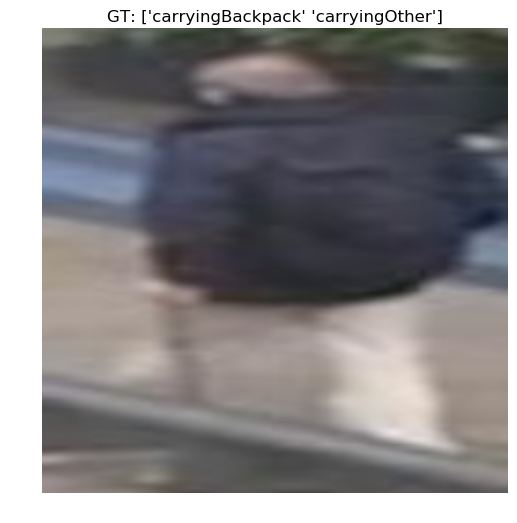

In [7]:
LABELS = ['hairLong', 'personMale', 'carryingBackpack','accessoryHat',\
                              'carryingOther','personalLess30', 'upperBodyVNeck']
LABELS = np.array(LABELS)
transformer = tools.SimpleTransformer() # This is simply to add back the bias, re-shuffle the color channels to RGB, and so on...
image_index = 0 # First image in the batch.
plt.figure()
plt.imshow(transformer.deprocess(copy(solver.net.blobs['data'].data[image_index, ...])))
gtlist = solver.net.blobs['label'].data[image_index, ...].astype(np.int)
plt.title('GT: {}'.format(LABELS[np.where(gtlist)]))

plt.axis('off');

* NOTE: we are readin the image from the data layer, so the resolution is lower than the original PASCAL image.

### 4. Train a net.

* Let's train the net. First, though, we need some way to measure the accuracy. Hamming distance is commonly used in multilabel problems. We also need a simple test loop. Let's write that down. 

In [8]:
def hamming_distance(gt, est):
    return sum([1 for (g, e) in zip(gt, est) if g == e]) / float(len(gt))

def check_accuracy(net, num_batches, batch_size = 128):
    acc = 0.0
    for t in range(num_batches):
        net.forward()
        gts = net.blobs['label'].data
        ests = net.blobs['score'].data > 0
        for gt, est in zip(gts, ests): #for each ground truth and estimated label vector
            acc += hamming_distance(gt, est)
    return acc / (num_batches * batch_size)

* Alright, now let's train for a while

In [ ]:
for itt in range(5):
    solver.step(100)
    print 'itt:{:3d}'.format((itt + 1) * 100), 'accuracy:{0:.4f}'.format(check_accuracy(solver.test_nets[0], 50))

itt:100 accuracy:0.8593


* Great, the accuracy is increasing, and it seems to converge rather quickly. It may seem strange that it starts off so high but it is because the ground truth is sparse. There are 20 classes in PASCAL, and usually only one or two is present. So predicting all zeros yields rather high accuracy. Let's check to make sure.

In [ ]:
def check_baseline_accuracy(net, num_batches, batch_size = 128):
    acc = 0.0
    for t in range(num_batches):
        net.forward()
        gts = net.blobs['label'].data
        ests = np.zeros((batch_size, len(gts)))
        for gt, est in zip(gts, ests): #for each ground truth and estimated label vector
            acc += hamming_distance(gt, est)
    return acc / (num_batches * batch_size)

print 'Baseline accuracy:{0:.4f}'.format(check_baseline_accuracy(solver.test_nets[0], 5823/128))

### 6. Look at some prediction results

In [ ]:
test_net = solver.test_nets[0]
for image_index in range(30):
    plt.figure()
    plt.imshow(transformer.deprocess(copy(test_net.blobs['data'].data[image_index, ...])))
    gtlist = test_net.blobs['label'].data[image_index, ...].astype(np.int)
    estlist = test_net.blobs['score'].data[image_index, ...] > 0
    plt.title('GT: {} \n EST: {}'.format(LABELS[np.where(gtlist)], LABELS[np.where(estlist)]))
    plt.axis('off')